# XGBoost

- 분류에 있어서 일반적으로 다른 머신러닝보다 조금은 뛰어난 예측 성능을 나타냄
- XGBoost는 GBM에 기반하고 있지만, GBM의 단점인 느린 수행시간 및 과적합 규제(Regularization) 부재 등의 문제를 해결함
- 특히 병렬 CPU 환경에서 병렬학습이 가능해 기존 GBM 보다 빠르게 학습을 완료

XGBoost의 주요 장점

![image](https://user-images.githubusercontent.com/70187490/129191162-070d585d-09df-48f8-9a72-70b11c386db7.png)


XGBoost는 파이썬에서 구동하는 버전과 사이킷런에서 구동하는 버전 둘로 나뉨  
- 파이썬 패키지
    - 파이썬 패키지의 역할은 대부분 C/C++ 핵심 라이브러리를 호출하는 것
    - XGBoost의 파이썬 패키지명은 "xgboost"
    - 사이킷런 프레임워크를 기반으로 한것이 아니기에 fit( ), predict( ) 메서드가 사용되지 못함
    - 파이썬 XGBoost는 고유의 API와 하이퍼 파라미터를 이용함

<br>

# 파이썬 래퍼 XGBoost 하이퍼 파라미터
XGBoost는 GBM과 유사한 하이퍼 파라미터를 동일하게 가지고 있으며, 여기에 조기 중단(early stopping), 과적합을 규제하기 위한 하이퍼 파라미터 등이 추가 되었음  
파이썬 래퍼 XGBoost 모듈과 사이킷런 래퍼XGBoost모듈의 일부 하이퍼 파라미터의 범용화된 이름 규칙(Naming Rule)에 따라 파라미터 명이 달라짐  
<br>
파이썬 래퍼 XGBoost 하이퍼 파라미터의 유형
- 일반 파라미터: 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
- 부스터 파라미터: 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭
- 학습 태스크 파라미터: 학습 수행시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

## 주요 일반 파라미터

![image](https://user-images.githubusercontent.com/70187490/129195774-5062d5e0-8d65-4958-8634-b49c28f98a87.png)



## 주요 부스터 파라미터
![image](https://user-images.githubusercontent.com/70187490/129198010-7e758d6d-ac79-4194-aa0f-e83cf8e09daa.png)
![image](https://user-images.githubusercontent.com/70187490/129216004-db5cf5d0-05db-45b5-a270-95644e873cff.png)

## 학습 태스크 파라미터
![image](https://user-images.githubusercontent.com/70187490/129217700-dc0a4959-e81b-4edc-92a8-94793369760e.png)


과적합 문제가 심각하다면 다음과 같이 적용
- eta 값을 낮춤(0.01 ~ 0.1). eta 값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야 함
- max_depth 값을 낮춤
- min_child_weight 값을 높임
- gamma 값을 높임
- 또한 subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 됨


In [1]:
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [2]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [3]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)
print(X_train.shape)
print(X_test.shape)

(455, 30)
(114, 30)


In [4]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [5]:
params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds=400

In [6]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval'로 명기
wlist=[(dtrain,'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model= xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist, verbose_eval=True)

[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train-logloss:0.19218	eval-logloss:0.23156
[13]	train-logloss:0.17792	eval-logloss:0.22005
[14]	train-logloss:0.16522	eval-logloss:0.20857
[15]	train-logloss:0.15362	eval-logloss:0.19999
[16]	train-logloss:0.14333	eval-logloss:0.19012
[17]	train-logloss:0.13398	eval-logloss:0.18182
[18]	train-logloss:0.12560	eval-logloss:0.17473
[19]	train-logloss:0.11729	eval-logloss:0.16766
[20]	train-logloss:0.10969	eval-logloss:0.15820
[2

[170]	train-logloss:0.00708	eval-logloss:0.08730
[171]	train-logloss:0.00707	eval-logloss:0.08737
[172]	train-logloss:0.00705	eval-logloss:0.08740
[173]	train-logloss:0.00703	eval-logloss:0.08739
[174]	train-logloss:0.00701	eval-logloss:0.08713
[175]	train-logloss:0.00699	eval-logloss:0.08716
[176]	train-logloss:0.00697	eval-logloss:0.08696
[177]	train-logloss:0.00696	eval-logloss:0.08705
[178]	train-logloss:0.00694	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.08697
[180]	train-logloss:0.00690	eval-logloss:0.08704
[181]	train-logloss:0.00688	eval-logloss:0.08680
[182]	train-logloss:0.00687	eval-logloss:0.08683
[183]	train-logloss:0.00685	eval-logloss:0.08658
[184]	train-logloss:0.00683	eval-logloss:0.08659
[185]	train-logloss:0.00681	eval-logloss:0.08661
[186]	train-logloss:0.00680	eval-logloss:0.08637
[187]	train-logloss:0.00678	eval-logloss:0.08637
[188]	train-logloss:0.00676	eval-logloss:0.08630
[189]	train-logloss:0.00675	eval-logloss:0.08610
[190]	train-logloss:

In [7]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정해 리스트 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [12]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion.shape[0]):
        for z in range(confusion.shape[1]):
            ax.text(x=z, y=i, s= confusion[i,z], va='center', ha='center', fontsize=19)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

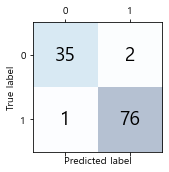

정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870, F1: 0.9806, AUC: 0.9951


In [13]:
get_clf_eval(y_test, preds, pred_probs)

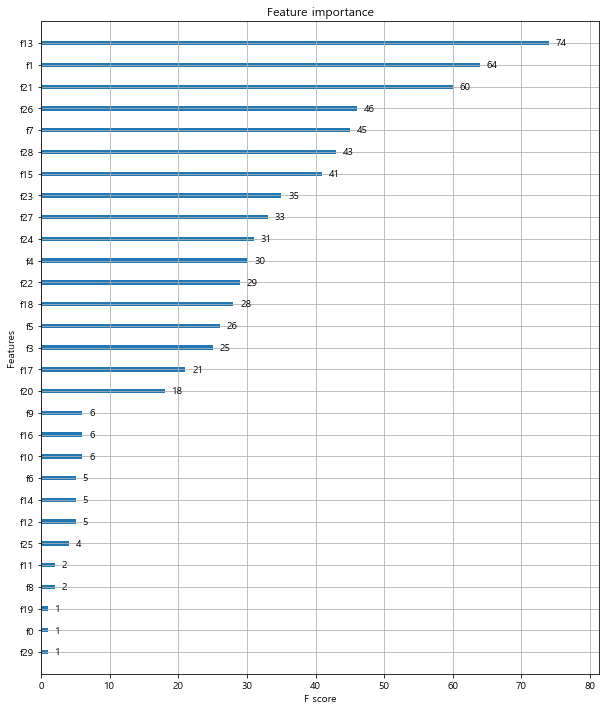

In [17]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax);